<a href="https://colab.research.google.com/github/talhaanwarch/my_pytorch/blob/master/coivd_tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
#TPU
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
#file reading packages
!pip install pydicom
!pip install pylibjpeg
!pip install gdcm
!pip install pylibjpeg-libjpeg
!pip install numpy --upgrade --ignore-installed
#pytorch stuff
!pip install pytorch-lightning
!pip install torchmetrics


In [ ]:
import numpy as np
assert np.__version__=='1.20.3', 'Numpy version should be 1.20.3'

In [ ]:
import os
if (os.path.isfile('COVIDCTMD.zip')) or (os.path.isdir('data')) is False:
  !wget https://s3-eu-west-1.amazonaws.com/pstorage-npg-968563215/26069987/COVIDCTMD.zip

In [ ]:
%%capture
if os.path.isdir('data') is False:
  !mkdir data
  !unzip /content/COVIDCTMD.zip -d data
  !rm /content/COVIDCTMD.zip

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pydicom as dicom
from glob import glob
import cv2

In [ ]:
!rm -rf /content/data/__MACOSX

In [ ]:
# clinical_features=pd.read_csv('/content/Clinical-data.csv')
# clinical_features.head()

In [ ]:
# df=pd.read_csv('/content/Index.csv')
# df.head()

In [ ]:
# df=pd.read_csv('/content/Radiogists-seperated-labels.csv')
# df.head()

2721 0
255 0


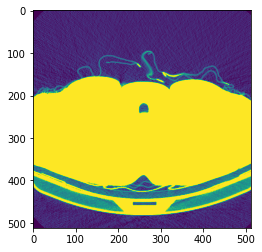

In [ ]:
import pydicom as dicom
ds = dicom.dcmread('/content/data/Normal Cases/normal001/IM0001.dcm')
x=np.array(ds.pixel_array)
print(x.max(),x.min())
x = cv2.convertScaleAbs(x)
print(x.max(),x.min())
plt.imshow(x)

In [ ]:
'''
This code work for 2D slices of 3D.
It load it into the dataframe
'''

'\nThis code work for 2D slices of 3D.\nIt load it into the dataframe\n'

In [ ]:
def flatten(path,label=None):
  '''
  flatten list to single list
  path: images path in a list
  label: corresponding label in list
  '''
  path = [item for sublist in path for item in sublist]
  label = [item for sublist in label for item in sublist]
  return path, label

In [ ]:
def prepare_data(path='data',split=True,createDF=True):
  '''
  read data as dataframe 
  path: path of main directory in which classes are present
  split: split data to train and val
  convertDF: create dataframe or return list
  '''
  main_path=glob(path+'/*/')
  image_paths,image_labels=[],[]
  for class_folder in main_path: #iterate class folder
    for subject_folder in glob(class_folder+'*/'):#iterate subject folder
      subjects_paths,subject_labels=[],[]
      for img in glob(subject_folder+'/*.dcm'):#loop all images in subject folder
        subjects_paths.append(img)
        subject_labels.append(class_folder.split('/')[-2])
      image_paths.append(subjects_paths)
      image_labels.append(subject_labels)
  if split:
    train_path,val_path,train_label,val_label=train_test_split(image_paths,image_labels,test_size=0.2)
    train_path,train_label=flatten(train_path,train_label)
    val_path,val_label=flatten(val_path,val_label)
    if createDF:
      train_df=pd.DataFrame(zip(train_path,train_label),columns=['image','label'])
      val_df=pd.DataFrame(zip(val_path,val_label),columns=['image','label'])
      return train_df,val_df
    else:
      return train_path,val_path,train_label,val_label
  else:
    if createDF:
      image_paths,image_labels=flatten(image_paths,image_labels)
      df=pd.DataFrame(zip(image_paths,image_labels),columns=['image','label'])
      return 
    else:
      return image_paths,image_labels

In [ ]:
train_df,val_df=prepare_data(split=True,createDF=True)

In [ ]:
encode={k:v for v,k in enumerate(train_df.label.unique())}
decode={v:k for v,k in enumerate(train_df.label.unique())}

In [ ]:
train_df.label=train_df.label.map(encode)
train_df.head()

,image,label
0,data/Cap Cases/cap014/IM0051.dcm,0
1,data/Cap Cases/cap014/IM0118.dcm,0
2,data/Cap Cases/cap014/IM0154.dcm,0
3,data/Cap Cases/cap014/IM0021.dcm,0
4,data/Cap Cases/cap014/IM0048.dcm,0


In [ ]:
val_df.label=val_df.label.map(encode)
val_df.head()

,image,label
0,data/COVID-19 Cases/P117/IM0051.dcm,1
1,data/COVID-19 Cases/P117/IM0118.dcm,1
2,data/COVID-19 Cases/P117/IM0154.dcm,1
3,data/COVID-19 Cases/P117/IM0021.dcm,1
4,data/COVID-19 Cases/P117/IM0048.dcm,1


In [ ]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping
from torch.nn.functional import cross_entropy
from sklearn.utils import class_weight
from torchvision import transforms 
import torchvision.models as models
import torchmetrics
import torch#pytorch
from sklearn.utils import class_weight


In [ ]:
#as our image is in numpy, so converting to PIL to make tensor work
#https://stackoverflow.com/a/63607069/11170350
aug=transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize((224,224)),
                        transforms.Grayscale(),
                        transforms.CenterCrop(224),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomRotation(degrees=3),
                        transforms.RandomPerspective(0.05,0.2),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, ], [0.5,]),

                        ])

In [ ]:
from torch.utils.data import DataLoader, Dataset
class DataReader(Dataset):
  def __init__(self,df,transform=None):
    super(DataReader,self).__init__()
    self.df=df
    self.transform=transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self,index):
    image_path=self.df.image[index]
    image_label=self.df.label[index]

    #read data
    image = dicom.dcmread(image_path).pixel_array
    #image=np.array(image)
    image = cv2.convertScaleAbs(image)

    if self.transform:
      image=self.transform(image)

    return image,image_label

In [ ]:
# #testing above code
# batch=next(iter(DataLoader(DataReader(train_df,aug), batch_size = 8, num_workers=1,shuffle=True)))
# print(batch[0][0].shape)

# from torch.utils.data.dataloader import DataLoader
# import torchvision
# import matplotlib.pyplot as plt
# grid_img=torchvision.utils.make_grid(batch[0],4,4)
# plt.imshow(grid_img.permute(1, 2, 0))

In [ ]:
import torch.nn as nn
class Fire1(nn.Module):
   
    def __init__(self, in_channels, squeeze_channels,expand_channels):
        super(Fire1, self).__init__()

        # squeeze 
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.relu = nn.LeakyReLU()

        # expand
        self.expand_1x1 =nn.Conv2d(squeeze_channels, expand_channels, kernel_size=1)
        self.expand_3x3 =nn.Conv2d(squeeze_channels, expand_channels, kernel_size=3,padding=1)
        

    def forward(self, x):
        x = self.squeeze(x)
        x= self.relu(x)
        x = torch.cat([self.expand_1x1(x),self.expand_3x3(x)], dim=1)
        x = self.relu(x)
        return x
    
    
class MyModelV3(torch.nn.Module):
    
    def __init__(self,num_classes):
        super(MyModelV3, self).__init__()
        self.num_classes=num_classes
        self.net = torch.nn.Sequential(
                 nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=2),
                 nn.MaxPool2d(kernel_size=3,stride=2),
                 nn.ReLU(),
                 nn.BatchNorm2d(32),
                 Fire1(in_channels=32, squeeze_channels=16,expand_channels=32),
                 Fire1(in_channels=64, squeeze_channels=16,expand_channels=64),
                 nn.MaxPool2d(kernel_size=3,stride=2),
                 nn.Dropout(0.5),
                 Fire1(in_channels=128, squeeze_channels=32,expand_channels=96),
                 Fire1(in_channels=192, squeeze_channels=32,expand_channels=128),
                 nn.MaxPool2d(kernel_size=3,stride=2),
                 nn.Dropout(0.25),
                 Fire1(256, 48, 160),
                 Fire1(320, 48, 160),
                 nn.Dropout(0.5),
                 nn.Conv2d(in_channels=320,out_channels=128*2,kernel_size=1,stride=2),
                 nn.ReLU(),
                 nn.Conv2d(in_channels=128*2,out_channels=32,kernel_size=1,stride=1),
                 nn.ReLU(),
                 nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1,stride=1),
                 nn.ReLU(),
                 nn.Dropout(0.5),
                 nn.Flatten(),
                 nn.Linear(784, self.num_classes),
                               
                )        
    def forward(self, x):
        return self.net(x)

In [ ]:
x=torch.randn(3,1,224,224)
model=MyModelV3(4)
model(x).shape

torch.Size([3, 4])

In [ ]:
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer =MyModelV3(3)
    
  #parameters
    self.lr=0.001
    self.batch_size=128
    self.numworker=1
    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()
    self.class_weights =torch.tensor(class_weight.compute_class_weight('balanced',\
                  np.unique(train_df.label),train_df.label),dtype=torch.float32)
    
  def forward(self,x):
    return self.layer(x)

 

  def configure_optimizers(self):
    return torch.optim.AdamW(params=self.parameters(),lr=self.lr )

  def train_dataloader(self):
    return DataLoader(DataReader(train_df,aug), batch_size = self.batch_size, num_workers=self.numworker,shuffle=True)

  def training_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=torch.nn.functional.cross_entropy(out,label,self.class_weights)
    pred=torch.max(out,dim=1)[1]
    train_acc=self.train_acc(pred,label)
    self.log('train/acc', train_acc, on_epoch=True,prog_bar=True)
    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    return DataLoader(DataReader(val_df,aug), batch_size = self.batch_size,num_workers=self.numworker,  shuffle=False)
    
  def validation_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=torch.nn.functional.cross_entropy(out,label,self.class_weights)
    pred=torch.max(out,dim=1)[1]
    valid_acc=self.val_acc(pred,label)
    self.log('vall/acc', valid_acc, on_epoch=True,prog_bar=True)
    self.log('vall/loss', loss, on_epoch=True,prog_bar=True)
    return loss


In [ ]:
early_stop_callback = EarlyStopping(monitor='vall/loss', min_delta=0.00, patience=2, verbose=True, mode='min')
model = OurModel()
trainer = Trainer(max_epochs=6, auto_lr_find=False, auto_scale_batch_size=False,
                  tpu_cores=8,precision=16,
                  #gpus=-1,
                  progress_bar_refresh_rate=30, 
                  callbacks=[early_stop_callback]
                  )
trainer.tune(model)
trainer.fit(model)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores

  | Name      | Type      | Params
----------------------------------------
0 | layer     | MyModelV3 | 375 K 
1 | train_acc | Accuracy  | 0     
2 | val_acc   | Accuracy  | 0     
----------------------------------------
375 K     Trainable params
0         Non-trainable params
375 K     Total params
0.750     Total estimated model params size (MB)


[rank: 5] Metric vall/loss improved. New best score: 1.100
[rank: 0] Metric vall/loss improved. New best score: 1.103
[rank: 2] Metric vall/loss improved. New best score: 1.091
[rank: 6] Metric vall/loss improved. New best score: 1.099
[rank: 1] Metric vall/loss improved. New best score: 1.084
[rank: 3] Metric vall/loss improved. New best score: 1.092
[rank: 7] Metric vall/loss improved. New best score: 1.101
[rank: 4] Metric vall/loss improved. New best score: 1.100


[rank: 7] Metric vall/loss improved by 0.006 >= min_delta = 0.0. New best score: 1.095
[rank: 0] Metric vall/loss improved by 0.001 >= min_delta = 0.0. New best score: 1.101


[rank: 5] Metric vall/loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099
[rank: 2] Monitored metric vall/loss did not improve in the last 2 records. Best score: 1.091. Signaling Trainer to stop.
[rank: 3] Monitored metric vall/loss did not improve in the last 2 records. Best score: 1.092. Signaling Trainer to stop.
[rank: 1] Monitored metric vall/loss did not improve in the last 2 records. Best score: 1.084. Signaling Trainer to stop.
[rank: 6] Metric vall/loss improved by 0.000 >= min_delta = 0.0. New best score: 1.098
[rank: 4] Metric vall/loss improved by 0.002 >= min_delta = 0.0. New best score: 1.098
[rank: 0] Metric vall/loss improved by 0.006 >= min_delta = 0.0. New best score: 1.095


[rank: 3] Monitored metric vall/loss did not improve in the last 3 records. Best score: 1.092. Signaling Trainer to stop.
[rank: 5] Metric vall/loss improved by 0.002 >= min_delta = 0.0. New best score: 1.097
[rank: 7] Monitored metric vall/loss did not improve in the last 2 records. Best score: 1.095. Signaling Trainer to stop.
[rank: 1] Monitored metric vall/loss did not improve in the last 3 records. Best score: 1.084. Signaling Trainer to stop.
[rank: 2] Monitored metric vall/loss did not improve in the last 3 records. Best score: 1.091. Signaling Trainer to stop.


[rank: 1] Monitored metric vall/loss did not improve in the last 4 records. Best score: 1.084. Signaling Trainer to stop.
[rank: 5] Metric vall/loss improved by 0.001 >= min_delta = 0.0. New best score: 1.096
[rank: 7] Monitored metric vall/loss did not improve in the last 3 records. Best score: 1.095. Signaling Trainer to stop.
[rank: 4] Monitored metric vall/loss did not improve in the last 2 records. Best score: 1.098. Signaling Trainer to stop.
[rank: 2] Monitored metric vall/loss did not improve in the last 4 records. Best score: 1.091. Signaling Trainer to stop.
[rank: 6] Monitored metric vall/loss did not improve in the last 2 records. Best score: 1.098. Signaling Trainer to stop.
[rank: 0] Monitored metric vall/loss did not improve in the last 2 records. Best score: 1.095. Signaling Trainer to stop.
[rank: 3] Monitored metric vall/loss did not improve in the last 4 records. Best score: 1.092. Signaling Trainer to stop.


[rank: 7] Monitored metric vall/loss did not improve in the last 4 records. Best score: 1.095. Signaling Trainer to stop.
[rank: 4] Metric vall/loss improved by 0.002 >= min_delta = 0.0. New best score: 1.096
[rank: 6] Metric vall/loss improved by 0.000 >= min_delta = 0.0. New best score: 1.098
[rank: 2] Monitored metric vall/loss did not improve in the last 5 records. Best score: 1.091. Signaling Trainer to stop.
[rank: 0] Monitored metric vall/loss did not improve in the last 3 records. Best score: 1.095. Signaling Trainer to stop.
[rank: 3] Monitored metric vall/loss did not improve in the last 5 records. Best score: 1.092. Signaling Trainer to stop.
[rank: 1] Monitored metric vall/loss did not improve in the last 5 records. Best score: 1.084. Signaling Trainer to stop.


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: cleaning up ddp environment...
  warnings.warn(*args, **kwargs)


In [ ]:
!rm -rf /content/lightning_logs